In [13]:
import pandas as pd
from typing import Any, cast
import os
import json
import pickle

os.chdir("C:/Users/jerem/OneDrive/Documents/rocketleague_ml")
file_type = cast(str, "json")
file_name = "replay"
player_name = "CallMeBigSenior"

processed_file = f"data/processed/{file_type}/replay.{file_type}"
loader = pickle if file_type == "pkl" else json

with open(processed_file, "rb") as f:
    game = loader.load(f)

def get_player_updates():
    if file_type == "pkl":
        for player in game.players().values():
            if player.name == player_name and player.car:
                return player.car.updates_by_round
        raise ValueError("Could not find player {player_name}")
    if file_type == "json":
        for player in game["players"].values():
            if player["name"] == player_name and player["car"]:
                return player["car"]["updates_by_round"]
        raise ValueError("Could not find player {player_name}")

In [14]:
def get_positioning_for_player_by_round(updates_by_round: Any, round: int):
    round_key = str(round) if file_type == "json" else round
    positioning = pd.DataFrame(updates_by_round[round_key])
    positioning.head()

    loc_positioning = pd.json_normalize(positioning["location"]) # type: ignore
    loc_positioning.columns = [f"location_{c}" for c in loc_positioning.columns]

    # Expand 'rotation' into its own columns
    rot_positioning = pd.json_normalize(positioning["rotation"]) # type: ignore
    rot_positioning.columns = [f"rotation_{c}" for c in rot_positioning.columns]

    # Expand 'linear_velocity'
    linvel_positioning = pd.json_normalize(positioning["linear_velocity"]) # type: ignore
    linvel_positioning.columns = [f"linear_velocity_{c}" for c in linvel_positioning.columns]

    # Same for angular_velocity (if not all None)
    angvel_positioning = pd.json_normalize(positioning["angular_velocity"]) # type: ignore
    angvel_positioning.columns = [f"angular_velocity_{c}" for c in angvel_positioning.columns]

    # Concatenate back
    positioning = pd.concat(
        [positioning.drop(["location", "rotation", "linear_velocity", "angular_velocity"], axis=1),
        loc_positioning, rot_positioning, linvel_positioning, angvel_positioning],
        axis=1
    )
    positioning["location_x"] = -positioning["location_x"]
    # positioning["location_y"] = -positioning["location_y"]
    return positioning

# XY Positioning

-5622.86 5982.4


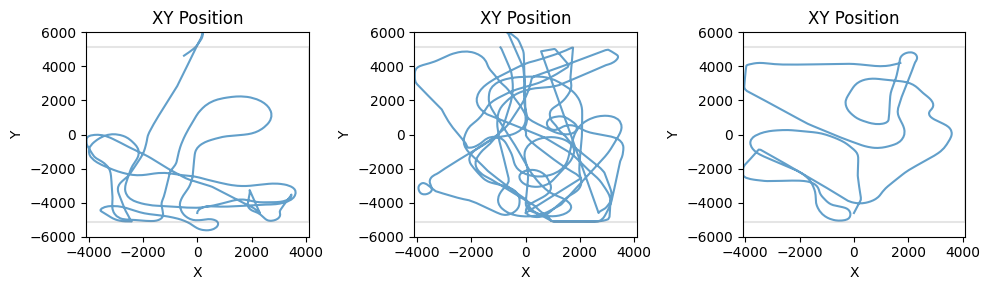

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

rounds = game.round - 1 if file_type == "pkl" else game["rounds"] - 1
rows = 3 if rounds % 3 == 0 else 2 if rounds % 2 == 0 else 1
cols = int(rounds / rows)
fig, axes = plt.subplots(cols, rows, figsize=(10 * cols, rows)) # type: ignore

# flatten axes into a list for consistent indexing
if isinstance(axes, np.ndarray):
    axes = axes.ravel() # type: ignore
else:
    axes = [axes]

field_x = [-4096, 4096, 4096, -4096, -4096]
field_y = [-5120, -5120, 5120, 5120, -5120]

# Left: 2D XY position
player_updates = get_player_updates()
for round in range(rounds):
    round_positioning = get_positioning_for_player_by_round(player_updates, round + 1)
    if round == 0:
        y_min, y_max = round_positioning["location_y"].min(), round_positioning["location_y"].max()
        print(y_min, y_max)
    axes[round].plot(round_positioning["location_x"], round_positioning["location_y"], alpha=0.7)
    # Add field outline (approx Rocket League dimensions: 8192x10240 uu)
    axes[round].plot(field_x, field_y, color="grey", alpha=0.2)
    axes[round].set_title("XY Position")
    axes[round].set_xlabel("X")
    axes[round].set_ylabel("Y")
    axes[round].set_xlim(field_x[0], field_x[1])
    axes[round].set_ylim(-6000, 6000)
    axes[round].set_ylabel("Y")

plt.tight_layout()
plt.show() # type: ignore